In [1]:
# these are the Classes used from the Shapely library
# - https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import LinearRing

# these are the different cap styles for the "buffer" function
from shapely.geometry import CAP_STYLE, JOIN_STYLE

# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os


from shapely_conversion import convert


In [2]:
'''
Evenly sample the linestring
'''
def sample(ls, distance):
    
    pos = 0
    
    points = []
    
    while pos < ls.length:
        points.append(ls.interpolate(pos))
        
        pos += distance
        
    return points   

In [3]:
'''
Recursively run the distance transform on the input polygon
- if result is empty, terminate with empty list
- if result is Polygon, add current Polygon
- if result is MultiPolygon, run for each Polygon in the MultiPolygon
'''
def distance_transform(polygon, distance):
        
    t = polygon.buffer(distance, cap_style = CAP_STYLE.flat, join_style = JOIN_STYLE.mitre)
    
    # if t is empty, return the empty list
    if not t:
        return []
        
    result = []

    # MultiPolygons are the result of concave shapes ~ distance transform creates multiple polygons
    if t.type == "MultiPolygon":
        for p in t:
            result.append([p])
            result[-1].extend(distance_transform(p, distance))
    else:
        result.append(t)
        result.extend(distance_transform(t, distance))
        
    return result


'''
Plot all of the contours of an input polygon
'''
def plot_poly(polygon):
    plt.plot(*polygon.exterior.xy)
    
    for i in polygon.interiors:
        plt.plot(*i.xy)


'''
Plot all of the contours in the result of a distance transform
'''
def plot_contours(result):
    for p in result:
        if type(p) is list:
            plot_contours(p)
        else:
            plot_poly(p)

In [4]:
'''
Cut a linestring at a specified distance. This always returns at least one linestring and a None, or two linestrings
'''
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0:
        return [None, LineString(line)]
    elif distance >= line.length:
        return [LineString(line), None]
    
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]
    # this is between the last point
    # this is to catch for linear rings (last point projection is 0)
    cp = line.interpolate(distance)
    return [
        LineString(coords[:-1] + [(cp.x, cp.y)]),
        LineString([(cp.x, cp.y)] + [coords[-1]])]

'''
Reformat the linestring so position 0 is the start point. This may involve inserting a new point into the contour.
'''
def cycle(contour, point):
    
    # find the point projection on the contour
    proj = contour.project(point)
    
    # cut the contour at the projection distance
    result = cut(contour, proj)
    
    if result[0] is None:
        points = result[1]
    elif result[1] is None:
        points = result[0]
    else:
        [ls1,ls2] = result
        points = list(ls2.coords) + list(ls1.coords)

    return LineString(points)

In [5]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [6]:
'''
Generate a spiral path from an input family of contours
'''
def spiral_path(contour_family, distance):

    points = []

    if not contour_family:
        return points
    
    # set the start contour
    contour = contour_family[0].exterior
    
    # set the starting point as p0 (arbitrary)
    start = Point(contour.coords[0])
    
    # calculate the end point a distance away from the end of the contour
    end = calculate_point(contour, contour.length, distance, forward=False)
    
    # if the end point was not found, return an empty list ~ contour is too small
    if end is None:
        return []
    
    # add the points before the reroute point to the path
    ls, _ = cut(contour, contour.project(end))                
    points.extend(ls.coords)
    
    # the previous contour is used to force the point away from acute angles
    previous = contour
    
    # loop through each "inner" contour
    for polygon in contour_family[1:]:
        
        contour = polygon.exterior
        
        # get the next start point
        start = contour.interpolate(contour.project(end))
                
        # cycle so the start point is the coordinate at index 0
        contour = cycle(contour, start)
                
        # calculate the end point a distance away from the previous contour
        end = calculate_point_contour(contour, previous, distance)
                
        if end is None:
            break

        # add the points before the reroute point to the path
        ls, _ = cut(contour, contour.project(end))                
        points.extend(ls.coords)
        
        # set the previous to the processed contour so the next spiral generation can measure the distance from this
        previous = contour
        
    return points

In [7]:
'''
Build the outer spiral of the fermat spiral
'''  
def outer_spiral(path, distance):
    
    print("OUTER")
    path = LineString(path)
    
    # start at the first point in the contour
    start = Point(path.coords[0])
    
    spiral = []
    outer_pieces = []

    while True:
        # find the "end" point of the contour, which is the point that is projected once around the contour
        end = calculate_break(path, start, distance)

        # return if the end point is the end of the path
        if end is None or path.project(end) == path.length:   
            return spiral+list(path.coords), outer_pieces, True
        
        # get the reroute point away from the end towards start
        reroute = calculate_point(path, path.project(end), distance, forward=False)
        
        # cut the path at the reroute point
        p1,center = cut(path, path.project(reroute))

        # complete the reroute of the path at the end point
        center,p2 = cut(center, center.project(end))

        # get the inner point
        # - this is the point that is a distance farther than the projection distance
        start = calculate_break(p2, reroute, distance)

        # add these coordinates to the spirals
        spiral.extend(list(p1.coords))

        # if the length of the remaining path is where the next jump would be, break the loop
        if start is None or p2.project(start) == p2.length:    
            return spiral + list(p2.coords)[::-1], outer_pieces, True
        
        # cut the inner contour at this point
        outer, inner = cut(p2, p2.project(start))
        outer_pieces.append(outer)

        # set the path to the inner part of the spiral
        path = inner
        


In [8]:
'''
Build the inner spiral of the fermat spiral using the pieces of the spiral
'''
def inner_spiral(outer_pieces, distance, center, path):    
    spiral = []
    
    if len(outer_pieces) == 0:
        pass
    else:
        
        # reverse the outer pieces to go from inside to outside
        outer_pieces = outer_pieces[::-1]
        contour = outer_pieces[0]
        formatted_pieces = []
        
        # adjust the center position dependent on the type of center (center in or center out)
        if center:
            
            contour = outer_pieces[0]
            contour, _ = cut(contour, contour.project(Point(path[-1])))
            formatted_pieces.append(contour)
        else:
            # find the point away from the endpoint of the current piece
            reroute = calculate_point(contour, contour.length, distance, forward=False)
            
            # remove the points after the reroute on the next contour
            contour, _ = cut(contour, contour.project(Point(path[-1])))
            formatted_pieces.append(contour)
            
            ls = LineString(path)
            ls, _ = cut(ls, ls.project(Point(contour.coords[-1])))
            
            path = list(ls.coords)
            
        
        for contour in outer_pieces[1:]:
            
            # find the point away from the endpoint of the current piece
            reroute = calculate_point(contour, contour.length, distance, forward=False)
            # remove the points after the reroute on the next contour
            contour, _ = cut(contour, contour.project(reroute))
            
            formatted_pieces.append(contour)
            
            
        # loop through the formatted pieces
        for i in range(len(formatted_pieces)-1):
            
            # collect the current and next piece
            c0 = formatted_pieces[i]
            c1 = formatted_pieces[i+1]
            
            # project the end of the formatted end piece of the next contour on the inner contour
            dis = c0.project(Point(c1.coords[-1]))
            
            # if the projection is the start point, do not cut
            if dis == 0:
                spiral.extend(list(c0.coords)[::-1])
            else:
                _, inner = cut(c0,  dis)
                spiral.extend(list(c0.coords)[::-1])
                
        
        # add the last piece
        spiral.extend(list(formatted_pieces[-1].coords)[::-1])
    
    return path + spiral

In [9]:
def convert_fermat(path,distance, debug=False):
    
    if path is None or not path:
        return []
    
    path, pieces, center = outer_spiral(path, distance)
    
    return inner_spiral(pieces, distance, center, path)
    

In [10]:
# create a spiral path
def fermat_path(contours, distance,debug=False):
    
    path = spiral_path(contours, distance)
    
    if path:
        fermat = convert_fermat(path, distance,debug)
    else:
        fermat = path
    
    return fermat

In [11]:
# calculate a point a distance away from a position on the contour in a given direction
# this is where the contour is rerouted to the next spiral
# - contour: LineString input
# - position: starting position to measure from
# - radius: distance away from the starting point
# - forward: direction along the contour to find the point
def calculate_point(contour, position, radius, forward = True):
    
    # set the direction of the error
    direction = 1 if forward else -1
    
    # set the starting guess based on the direction
    error = direction * radius
    
    distance = position
    
    # save the start point for distance calculations
    start = contour.interpolate(position)
    
    # loop while the error is out of bounds 
    while abs(error) > 0.000001:
        
        distance += error
        
        # return None if the endpoints of the contour are reached
        if distance >= contour.length or distance <= 0:
            return None
        
        # get point
        point = contour.interpolate(distance)
        
        # calculate distance
        new_dis = point.distance(start)
        
        # calculate error
        error = direction * (radius - new_dis)/2
        
    return point


# calculate a point a distance away from a position on the contour in a given direction
# this is where the contour is rerouted to the next spiral
# - contour: LineString input
# - position: starting position to measure from
# - radius: distance away from the starting point
# - forward: direction along the contour to find the point
def calculate_point_contour(contour, previous, radius):

    
    # pick the ending point
    point = calculate_point(contour, contour.length , radius, forward = False)
    
    if point is None:
        return point
    
    # cut the path at the midpoint
    temp, _ = cut(contour, contour.length/2)
    
    # if the distance from the point to contour is the radius, return the point
    if radius - point.distance(temp) < 0.000001:
        return point
    
    # else find a valid distance and binary search to find valid point
    distance = contour.project(point)
    
    while point.distance(temp) < radius:
        
        distance -= radius
        
        if distance < 0:
            return None
        
        point = contour.interpolate(distance)
        
    max_error = contour.length - distance
    
    error = max_error/2
    
    position = distance + error
    
    point = contour.interpolate(position)
    
    
    # binary search the distance ~ uses some arbitrary amount of iteration? ~ set to 10 rn
    for i in range(10):
        
        error = error/2
        
        if point.distance(temp) < radius:
            position -= error
        else:
            position += error
            
        point = contour.interpolate(position)
        
    return point

# shift the point on the path if needed to make the distance at least the radius from the previous path
def shift_point(path, temp, point, radius):
    
    plot_path(path.coords, color='red')
    plot_path(temp.coords, color='green')
    plt.scatter(point.x,point.y)
    plt.show()
    if point is None:
        return point
    
    # if the distance from the point to contour is the radius, return the point
    if radius - point.distance(temp) < 0.000001:
        return point
    
    # else find a valid distance and binary search in between to find valid point
    distance = path.project(point)
    
    while point.distance(temp) < radius:
        
        distance -= radius
        
        if distance < 0:
            return None
        point = path.interpolate(distance)

        
    max_error = path.length - distance
    
    # start the guess half way between the error
    error = max_error/2
    position = distance + error
    point = path.interpolate(position)
    
    # binary search the distance ~ uses some arbitrary amount of iteration? ~ set to 10 rn
    # summation of 1/2^n starting at n=1 approaches 1 ~ so the range is 0-1
    # because error is 1/2 max_error, the range is 0-max error. We know max error must be valid, so the real answer must be in the range
    for i in range(10):
        
        error = error/2
        
        if path.distance(temp) < radius:
            position -= error
        else:
            position += error
            
        point = path.interpolate(position)
        
    return point

In [12]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    root = fermat_path(contour_family, distance,debug=False)

    # combine the root and the branches
    if root:
        return combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        return branches

In [13]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    results = spiral_path(contour_family, distance)

    total_path.append(results)

    return total_path

In [14]:
# this generates the total path without combining the paths
def generate_total_pathf(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_pathf(branch, distance))
        else:
            contour_family.append(branch)

    results = convert_fermat(spiral_path(contour_family, distance),distance)

    total_path.append(results)

    return total_path

In [15]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance ,fnc):
    
    total_path = []
    
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        # simplify the polygon to remove excess points - this helps with processing
        polygon = polygon.simplify(distance/2)
        
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
    
    return total_path

In [16]:
'''
Connect root and branch fermat spirals
'''
def combine_paths(root, branches, dis):
        
    root_ls = LineString(root)
        
    # find the start and end points of the root
    for b in branches:

        if not b:
            continue
        
        start = b[0]
        end = b[-1]
        
        
        # project end onto the root
        end_cut_dis = root_ls.project(Point(end))
        
        point = root_ls.interpolate(end_cut_dis)

        int_buff = point.buffer(dis)

        # get the line within the buffer distance of the point
        possible_line = int_buff.intersection(root_ls)

        start_pt = None
        
        if possible_line.type == "LineString":
            start_pt = possible_line.interpolate(possible_line.project(Point(start)))
        else:
            for item in possible_line:
                if item.type == "LineString":
                    # need to use this check instead of intersects because intersects will return false for some reason
                    test = item.interpolate(item.project(point))
                    if test == point:
                        start_pt = item.interpolate(item.project(Point(start)))
                        break

                
        start_cut_dis = root_ls.project(start_pt)        
                
        if start_cut_dis == 0:
            _,l2 = cut(root_ls, end_cut_dis)
            new_list = [root_ls.coords[0]] + b + list(l2.coords)
        elif end_cut_dis == 0:
            _,l2 = cut(root_ls, start_cut_dis)
            new_list = [root_ls.coords[0]] + b[::-1] + list(l2.coords)
        
        elif start_cut_dis == root_ls.length:
            l1,_ = cut(root_ls, end_cut_dis)
            new_list = list(l1.coords) + b + [root_ls.coords[-1]]

        elif end_cut_dis == root_ls.length:
            l1,_ = cut(root_ls, start_cut_dis)
            new_list =  list(l1.coords) + b[::-1] + [root_ls.coords[-1]]       

        
        elif start_cut_dis < end_cut_dis:
            
            l1,_ = cut(root_ls, start_cut_dis)
            _,l2 = cut(root_ls, end_cut_dis)
            
            new_list = list(l1.coords) + b + list(l2.coords)
        else:
            
            l1,_ = cut(root_ls, end_cut_dis)
            _,l2 = cut(root_ls, start_cut_dis)
            
            new_list =  list(l1.coords) + b[::-1] + list(l2.coords)       
        
        root_ls = LineString(new_list)
        
    return list(root_ls.coords)

In [17]:
'''
Find the next endpoint in the path
 - this is the endpoint one "loop" around the contour
 - the next endpoint should be where the projection distance is greater than the distance away from the start
'''
def calculate_break(path, start, radius):

    dis = 0
    
    while dis <= radius:
        _,path = cut(path,radius)
        
        if path is None:
            return None
        
        dis = path.project(start)
    
    
    return path.interpolate(dis)

In [19]:
%%time

'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 0.3

# filename of image to process
filename = 'files/area_test.png'

# image should be in binary format
image = cv2.imread(filename,0)

# generate the un-connected fermat spiral output
results = execute(image, distance, generate_total_pathf)


OUTER
P1
OUTER
P1
OUTER
P1
CPU times: user 37.3 ms, sys: 794 µs, total: 38.1 ms
Wall time: 37 ms


<IPython.core.display.Javascript object>


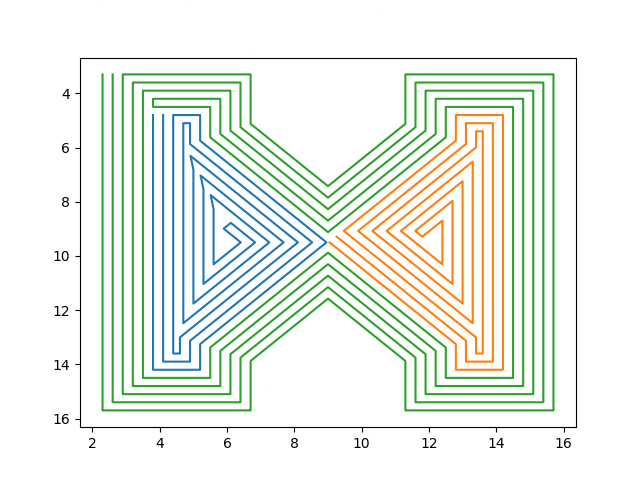

In [29]:
'''
For now, rerun this function if the display is not output
'''

%matplotlib notebook

# plot and show the path
plot_recursive_path(results)
plt.gca().invert_yaxis()

In [26]:
results

[[(3.799999999999999, 4.799999999999999),
  (3.799999999999999, 14.199999999999996),
  (5.200000000000001, 14.199999999999996),
  (5.200000000000001, 13.254415587728428),
  (8.954415587728434, 9.5),
  (5.200000000000001, 5.745584412271567),
  (5.200000000000001, 4.799999999999999),
  (4.4, 4.799999999999999),
  (4.400000000000001, 5.099999999999999),
  (4.399999999999998, 5.099999999999999),
  (4.399999999999999, 5.399999999999999),
  (4.399999999999999, 13.599999999999994),
  (4.600000000000001, 13.599999999999994),
  (4.600000000000001, 13.00588745030457),
  (8.105887450304579, 9.5),
  (4.911852624659869, 6.305965174355291),
  (5.000175115021282, 6.818551733428631),
  (4.999999999999998, 7.242640687119277),
  (4.999999999999998, 11.757359312880718),
  (7.257359312880723, 9.5),
  (5.512307149377245, 7.754947836496523),
  (5.60017511502128, 8.267079870852486),
  (5.599999999999998, 8.691168824543132),
  (5.599999999999998, 10.308831175456866),
  (6.408831175456867, 9.5),
  (5.900175115

In [21]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [22]:
# GCODE generation
# - this is used for converting the path into GCODE for the drawbot
# - applies an offset to each XY coordinate to avoid triggering the home flags repeatedly

x_offset = 2
y_offset = 2

# move the drawbot to a point
def command_move(p):
    return "G01 X" + str(p[0]+x_offset) + " Y" + str(p[1]+y_offset) + ";\n"

# move the pen up (drawbot specific)
def command_up():
    return "G01 Z0.5;\n"

# move the pen down (drawbot specific)
def command_down():
    return "G01 Z8.0;\n"

In [23]:
# GCODE generation
# - this takes the total path and creates a string of GCODE commands to follow the path
# - the expected input is a list of paths --> a single path should be in a list
def gcode(total_path, filename):
    
    # header function - home machine
    output = "G28 Z;\n"
    output += command_up()
    output += "G28 X Y;\n\n";
    
    for path in total_path:
        
        # move to p0
        output += command_move(path[0])
        
        # pen down
        output += command_down()
        
        # trace the path
        for p in path[1:]:
            output += command_move(p)
            
        # pen up
        output += command_up()
    
    # home machine
    output += "G28;\n"
    
    # print the number of commands
    print(len(output))
    
    # write the code to a gcode file
    f = open(filename, "w")
    f.write(output)
    f.close()
    
    # return the string (for debugging, not really needed)
    return output

In [24]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path

In [25]:
'''
BACKUP CODE
'''
raise

# this combines the root and branches path
def combine_paths_backup(root, branches, dis):
        
    root_ls = LineString(root)
        
    # find the start and end points of the root
    for b in branches:

        if not b:
            continue
        
        s1 = Point(b[0])
        e1 = Point(b[-1])
        
        s2 = Point(b[1])
        e2 = Point(b[-2])
        
        
        # extend the endpoints out of the spiral
        s3 = extend_line(s2,s1,dis*1)
        e3 = extend_line(e2,e1,dis*1)
        
        
        # compute the end point connection
        ds1 = root_ls.project(s3)
        ds2 = root_ls.project(e3)        
        
        if ds1 == 0:  # cut the root at ds2

            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = []
            ls2_list = list(root_ls.coords)[1:] # drop the first point   
        elif ds2 == 0:  # cut the root at ds2

            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = list(root_ls.coords)
            ls2_list = []
        elif ds1 == root_ls.length:
            # cut the root at ds2
            ls1, ls2 = cut(root_ls, ds1-dis)    
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds1)
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point   
        
        # if the start is the first cut
        elif ds1 < ds2:
            
            # cut the root at the start point
            ls1, ls2 = cut(root_ls, ds1)
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point   
        else:
            # cut the root at ds2
            ls1, ls2 = cut(root_ls, ds2)    
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds1)
        
        
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point        
        
        if ds1 < ds2:
            new_list = ls1_list + b + [end_point] + ls2_list
        else:
            new_list = ls1_list + b[::-1] + [end_point] + ls2_list        
        
        root_ls = LineString(new_list)
        
    return list(root_ls.coords)

RuntimeError: No active exception to reraise

In [ ]:
'''
BACKUP CODE
'''
raise

def calculate_break(path, start, distance):

    dis = 0
    
    while dis <= distance:
        _,path = cut(path,distance)
        
        dis = path.project(start)
    
    return path.interpolate(dis)
    

def point_distance(p1,p2):
    return np.sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)
    

def get_inner_point(path, reroute, distance):
    
    _, spiral = cut(path, distance)

    # while the projection is the end of the spiral, return
    while spiral.project(reroute) == 0:
        _, spiral = cut(spiral, distance)

    point = spiral.interpolate(spiral.project(reroute))
    
    return point
    
    
def center_inner(center, p2, distance):
    # reroute is the end of the spiral
    reroute = Point(p2.coords[0])

    # cut the center away from the next start
    end = calculate_end(center, Point(p2.coords[0]), distance)

    center, _ = cut(center, center.project(end))

    return center
    

# get the point a distance "upstream" of the point on the path
# - this is not a projection distance, but a straightline distance
def calculate_reroute(path, point, radius):
    
    buff = point.buffer(radius).exterior
        
    path,_ = cut(path, path.project(point))
        
    result = path.intersection(buff)
    
    if result.type == "Point":
        return result
    elif result.type == "MultiPoint":   
        return sorted(list(result), key = path.project)[-1]
    else:
         return result.interpolate(result.project(point))
    
    
'''
Build the outer spiral of the fermat spiral
'''  
def outer_spiral(path, distance):
    path = LineString(path)

    start = Point(path.coords[0])
    end = calculate_break(path, start, distance)

    spiral = []
    outer_pieces = []

    # start the inner loop
    while True:
        
        if path.project(end) == path.length:
            return spiral+list(path.coords), outer_pieces
        
        # get the reroute point away from the end towards start
        reroute = calculate_reroute(path, end, distance)

        # cut the path at the reroute point
        p1,center = cut(path, path.project(reroute))

        # complete the reroute of the path at the end point
        center,p2 = cut(center, center.project(end))

        # get the inner point
        # - this is the point that is a distance farther than the projection distance
        start = get_inner_point(p2, reroute, distance)

        # add these coordinates to the spirals
        spiral.extend(list(p1.coords))

        # if the length of the remaining path is where the next jump would be, break the loop
        if p2.length == p2.project(start):    
            return spiral+list(p2.coords)[::-1], outer_pieces

        # cut the inner contour at this point
        outer, inner = cut(p2, p2.project(start))
        outer_pieces.append(outer)

        # set the path to the inner part of the spiral
        path = inner
        end = calculate_break(path, start, distance)
       
'''
Build the inner spiral of the fermat spiral using the pieces of the spiral
'''
def inner_spiral(outer_pieces,start, distance):

    
    spiral = []
    
    if outer_pieces:
        
        # start from the center piece
        outer_pieces = outer_pieces[::-1]

        # get the projection from reroute
        d = outer_pieces[0].project(reroute)

        # loop through the contour pieces from the center
        for index, ls in enumerate(sp2[:-1]):

            # cut the point here
            if d > 0 and d < ls.length:
                p1,_ = cut(ls, d)
            else:
                p1 = ls

            # find the next reroute point from the start of the inner line
            d = outer_pieces[index+1].project(Point(p1.coords[0]))

            spiral.extend(list(p1.coords)[::-1])

        ls = outer_pieces[-1]  

        # cut the point here
        if d > 0 and d < ls.length:
            p1,_ = cut(ls, d)
        else:
            p1 = ls

        # add the last loop
        spiral.extend(list(p1.coords)[::-1])
        
        return spiral

    
# convert the spiral into the fermat spiral
def convert_fermat(path, distance,debug=False):
    
    debug_2 = False
    
    if path:
            
        spiral_outer, sp2 = outer_spiral(path, distance)
        
        spiral_inner = inner_spiral_distance(sp2, spiral_outer, distance)

        return spiral_outer + spiral_inner
    
    else:
        return []
